In [1]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA
import pandas as pd

%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

from tools import *

In [2]:
def clean_text(txt):
    lst = [i for i in txt.split('\n') if not (i[0] == '[' and i[1].isdigit())]
    lst = [s for i in lst for s in i.split('. ')]
    lst = [s for i in lst for s in i.split('.[')]
    lst = [i.strip() for i in lst if (len(i.split(' ')) > 3)]
    lst = [i for i in lst if len(i) > 1]
    lst = [i[i.index(']')+2:] if i.split(']')[0].isdigit() else i for i in lst]
    
    add = []
    for i in lst:
        i = i.replace(u'\xad', u"")
        i = i.replace(u'\\xad', u"")
        i = i.replace('-', "")
        i = i.replace('.ref', "")
        i = i.replace(u'\xa0', u' ')
        i = i.replace(u'\xa0', u' ')
        add.append(i)
        
    lst = add
    if "at The Heritage Foundation" in lst[-1]: 
        lst = lst[:-1]
    return lst

def reformat_sent(x, flat = False):
    lst = [i for i in x.split('], [')]
    lst = [i.strip('[[') for i in lst]
    lst = [i.strip(']]') for i in lst]
    lst = [i.split(',') for i in lst]
    new = []
    for i in lst:
        add = [a.strip(" '") for a in i]
        if flat: new.extend(add)
        else: new.append(add)
    return new

In [3]:
data = pd.read_csv('heritage_total_text.csv')
data = data.dropna()
data = data.reset_index()
data = data[['text', 'date', 'category']]
data.head()

,text,date,category
0,Yesterday the Senate decided to take up legisl...,"May 14th, 2014",energy-economics
1,The 2008 financial crisis was a major missed o...,"Sep 13th, 2018",housing
2,"It hasn't gotten much attention, but two big b...","Oct 19th, 2015",budget-and-spending
3,Authors: David Muhlhausen ...,"May 16, 2011",trade
4,"On April 5, 2005, the Georgetown Public Policy...","April 6, 2005",education


In [4]:
cleaned, wrong_index = [], []
for ind, txt in enumerate(data['text']):
    try: cleaned.append(clean_text(txt))
    except IndexError: 
        wrong_index.append(ind)
        
data = data.drop(data.index[wrong_index])
data.reset_index(drop=True, inplace=True)
data['cleaned_text'] = cleaned

In [18]:
normalized_sents = []
for ind, txt in enumerate(data['cleaned_text']):
    if ind % 2000 == 0: print(ind)
    add = [normalizeTokens(a) for a in txt]
    normalized_sents.append(add)

0
2000
4000
6000
8000
10000
12000
14000


In [20]:
data['normalized_sents'] = normalized_sents
#data.to_csv('cleaned_heritage.csv')
data.head()

,text,date,category,cleaned_text,normalized_sents
0,Yesterday the Senate decided to take up legisl...,"May 14th, 2014",energy-economics,[Yesterday the Senate decided to take up legis...,"[[yesterday, senate, decide, legislation, exte..."
1,The 2008 financial crisis was a major missed o...,"Sep 13th, 2018",housing,[The 2008 financial crisis was a major missed ...,"[[financial, crisis, major, miss, opportunity]..."
2,"It hasn't gotten much attention, but two big b...","Oct 19th, 2015",budget-and-spending,"[It hasn't gotten much attention, but two big ...","[[get, attention, big, budget, showdown, loom,..."
3,Authors: David Muhlhausen ...,"May 16, 2011",trade,[Authors: David Muhlhausen ...,"[[author, david, muhlhausen, james, sherk], [o..."
4,"On April 5, 2005, the Georgetown Public Policy...","April 6, 2005",education,"[On April 5, 2005, the Georgetown Public Polic...","[[april, georgetown, public, policy, institute..."


### Just Run This

In [3]:
### Recover Data
data = pd.read_csv('cleaned_heritage.csv')
data['normalized_sents'] = data['normalized_sents'].apply(lambda x: reformat_sent(x))
data.head()

,Unnamed: 0,text,date,category,cleaned_text,normalized_sents
0,0,Yesterday the Senate decided to take up legisl...,"May 14th, 2014",energy-economics,['Yesterday the Senate decided to take up legi...,"[[yesterday, senate, decide, legislation, exte..."
1,1,The 2008 financial crisis was a major missed o...,"Sep 13th, 2018",housing,['The 2008 financial crisis was a major missed...,"[[financial, crisis, major, miss, opportunity]..."
2,2,"It hasn't gotten much attention, but two big b...","Oct 19th, 2015",budget-and-spending,"[""It hasn't gotten much attention, but two big...","[[get, attention, big, budget, showdown, loom,..."
3,3,Authors: David Muhlhausen ...,"May 16, 2011",trade,['Authors: David Muhlhausen ...,"[[author, david, muhlhausen, james, sherk], [o..."
4,4,"On April 5, 2005, the Georgetown Public Policy...","April 6, 2005",education,"['On April 5, 2005, the Georgetown Public Poli...","[[april, georgetown, public, policy, institute..."


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using at least two different specification of `word2vec`, and visualize them each with two separate visualization layout specifications (e.g., TSNE, PCA). Then interrogate critical word vectors within your corpus in terms of the most similar words, analogies, and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the semantic organization of words in your corpora? Which estimation and visualization specification generate the most insight and appear the most robustly supported and why? 

<span style="color:red">***Stretch***: Explore different vector calculations beyond addition and subtraction, such as multiplication, division or some other function. What does this exploration reveal about the semantic structure of your corpus?

* I visualize the top 50 words with `TSNE` (`PCA` with 50 components and then `TSNE`) and `PCA` (2 components) seperately. The result are basically the same. Some patterns are interesting: for exaample, "health" is closer to "federal" than to "state," and "defense" is quite far away from "military." 
* I then visualize the keywords that represent major categories with `TSNE`. It is interesting that "defense" is closer to "energy" than to "nuclear," and "marriage" is closer to "budget" than to "social." 
* It is surprising to see that one of the words most similar to "conservatism" is "progressivism"--the similarity is even more than "republicanism" and "constitutionalism." This may suggest that, instead of explaning conservatism as itself, the Foundation often compares "conservatism" with its opposite ideology in the same paragraphs and even sentences. See an [example](https://www.heritage.org/conservatism/heritage-explains/the-3-big-differences-between-conservatives-and-progressives) here 
* It is also surprising to see that "trump" is mostly similar to "obama." 
* If we do the calculation of 'husband' - 'man' + 'woman' we can indeed get 'wife.' But the `similar_by_vector` function is different from `most_similar` in that the former does not exclude the words used for calculation. Therefore the word "husband" is also part of the results.
* If we simply add two vectors it shows the words with vectors right in the middle of them. That is, it shows word similar to both of them. I show this pattern by the following examples: 'energy' + 'policy' -> 'fuels', 'trump' + 'obama' -> 'bush', 'trade' + 'sanction'-> NAFTA.

In [4]:
#texts = data['normalized_sents'].sum()
#heritage_W2V = gensim.models.word2vec.Word2Vec(texts)
#heritage_W2V.save("heritage_WORD2Vec")
heritage_W2V = gensim.models.word2vec.Word2Vec.load("heritage_WORD2Vec")

In [5]:
heritage_W2V.most_similar('conservatism')

[('progressivism', 0.8517824411392212),
 ('liberalism', 0.8401990532875061),
 ('constitutionalism', 0.7963497638702393),
 ('republicanism', 0.7799617052078247),
 ('idealism', 0.7633888721466064),
 ('tradition', 0.7416598200798035),
 ('thinker', 0.7416388988494873),
 ('traditionalist', 0.7415279150009155),
 ('pragmatism', 0.7307913303375244),
 ('founder', 0.7273175716400146)]

In [6]:
heritage_W2V.most_similar('trump')

[('obama', 0.8369377851486206),
 ('bush', 0.7272510528564453),
 ('clinton', 0.6171241402626038),
 ('lambro', 0.5742717981338501),
 ('successive', 0.5234169960021973),
 ('reagan', 0.5211268067359924),
 ('rumsfeld', 0.4934632182121277),
 ('goodluck', 0.49293145537376404),
 ('carter', 0.4920475482940674),
 ('uribe', 0.4822132885456085)]

In [7]:
heritage_W2V.most_similar(positive=['trump', 'republican'], negative=['democrat'])

[('obama', 0.6859338283538818),
 ('bush', 0.5751690864562988),
 ('goodluck', 0.5337139368057251),
 ('successive', 0.528298020362854),
 ('mirziyoyev', 0.5153721570968628),
 ('uribe', 0.5106380581855774),
 ('clinton', 0.508777379989624),
 ('zedillo', 0.5013585686683655),
 ('reagan', 0.5008513331413269),
 ('eop', 0.4822203516960144)]

In [8]:
q = heritage_W2V['husband'] - heritage_W2V['man'] + heritage_W2V['woman']
heritage_W2V.similar_by_vector(q)

[('woman', 0.7499785423278809),
 ('husband', 0.6398215889930725),
 ('mother', 0.6339643001556396),
 ('spouse', 0.5787065029144287),
 ('parenting', 0.5448945164680481),
 ('wife', 0.518621563911438),
 ('maternal', 0.5179733037948608),
 ('cohabit', 0.5112078785896301),
 ('nonparents', 0.5108879208564758),
 ('unmarried', 0.5085097551345825)]

In [9]:
q = heritage_W2V['energy'] + heritage_W2V['policy']
heritage_W2V.similar_by_vector(q)

[('energy', 0.7611136436462402),
 ('policy', 0.7325103282928467),
 ('biofuel', 0.5276865363121033),
 ('renewable', 0.5201083421707153),
 ('environmentally', 0.4712294936180115),
 ('infrastructure', 0.45589587092399597),
 ('fuel', 0.4553101658821106),
 ('agendum', 0.44546693563461304),
 ('agriculture', 0.4306459128856659),
 ('technology', 0.4262164235115051)]

In [10]:
q = heritage_W2V['trump'] + heritage_W2V['obama']
heritage_W2V.similar_by_vector(q)

[('obama', 0.9598565101623535),
 ('trump', 0.9568527340888977),
 ('bush', 0.7996628284454346),
 ('clinton', 0.7205891609191895),
 ('successive', 0.5710030794143677),
 ('reagan', 0.5706114768981934),
 ('carter', 0.5556942224502563),
 ('goodluck', 0.5100587606430054),
 ('mirziyoyev', 0.503549337387085),
 ('lambro', 0.5003427267074585)]

In [11]:
q = heritage_W2V['trade'] + heritage_W2V['sanction']
heritage_W2V.similar_by_vector(q)

[('trade', 0.8202913999557495),
 ('sanction', 0.7179868221282959),
 ('fta', 0.6137950420379639),
 ('tariff', 0.60849928855896),
 ('tpp', 0.6013249754905701),
 ('ftas', 0.5900306701660156),
 ('nafta', 0.5868194103240967),
 ('wto', 0.5691407322883606),
 ('bilateral', 0.5648125410079956),
 ('export', 0.5556102395057678)]

In [12]:
numWords = 50
targetWords = heritage_W2V.wv.index2word[:numWords]

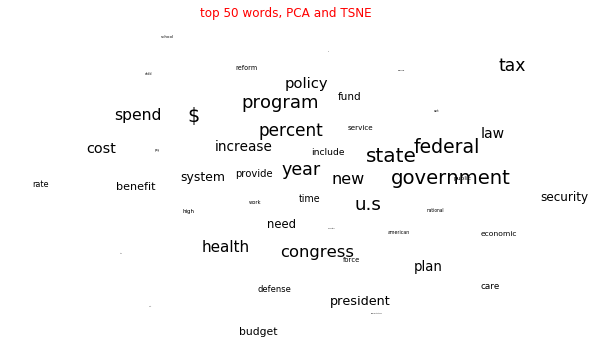

In [13]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(heritage_W2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)

pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.title('top 50 words, PCA and TSNE', color = 'red')
plt.show()

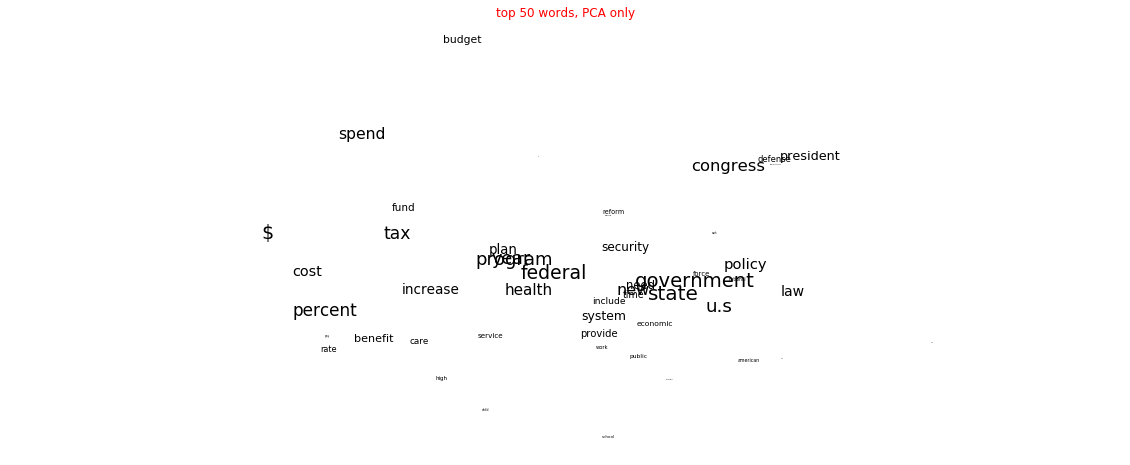

In [14]:
pcaWords = sklearn.decomposition.PCA(n_components = 2).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)

fig = plt.figure(figsize = (20,8))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0]/10, reducedPCA_data[:, 1], alpha = 0) 

for i, word in enumerate(targetWords):
    ax.annotate(word, (reducedPCA_data[:, 0][i], reducedPCA_data[:, 1][i]), 
                size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.title('top 50 words, PCA only', color = 'red')
plt.show()

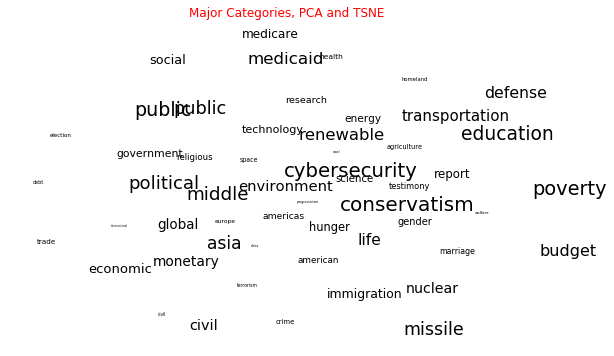

In [15]:
cat = set(data['category'])
targetWords = [i.split('-')[0] for i in cat]
targetWords.remove('the')
wordsSubMatrix = []

new_lst = []
for word in targetWords:
    if word in heritage_W2V:
        wordsSubMatrix.append(heritage_W2V[word])
        new_lst.append(word)
wordsSubMatrix = np.array(wordsSubMatrix)

pcaWords = sklearn.decomposition.PCA(n_components = 30).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(new_lst):
    ax.annotate(word, (tsneWords[:, 0][i], tsneWords[:, 1][i]), 
                size =  20 * (len(targetWords) - i) / len(targetWords))
plt.xticks(())
plt.yticks(())
plt.title('Major Categories, PCA and TSNE', color = 'red')
plt.show()

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using `doc2vec`, and explore the relationship between different documents and the word vectors you analyzed in the last exercise. Consider the most similar words to critical documents, analogies (doc _x_ + word _y_), and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the documentary organization of your semantic space?

* I label each documents with 30 keywords
* The `most_similar` function makes lots of sense as it calculates immigration - terrorirism as terrirorism - immigrants. 
* I also show that it detects the right texts that mention about woman - the top article's most similar words is "conjugal" and "revisionist," suggesting a strong tendency of connecting women's issue with marriage.
* The fact that the topics about woman and gay are so connected may explain why the article most similar to "woman" and "religious" is actually an article about how a Christian baker refused to design and create wedding cakes that celebrate same-sex marriages.
* Using word_woman - doc(most similar to woman) + word_tax, we can also locate the documents most similar to tax.
* I also use heatmap to visualize the connections among keywords and document-keyword. It seems that words like cybersecurity is quite different from words like worker and similar to terrorism.
* The document-keyword heatmap seems like a topic modeling method which summarizes each document's distance with different topics.

In [16]:
keywords = ['agriculture', 'education', 'congress', 'energy', 'family', 
            'religious', 'woman', 'conservatism', 'rights', 'crime',
            'courts', 'election', 'constitution', 'gun', 'health', 'asia', 'iran',
            'europe', 'cybersecurity', "technology", 'transportation', 'poverty', 'welfare',
            "housing", 'budget', 'immigration', 'terrorism', 'economy', 'tax', 'worker']

In [17]:
#taggedDocs = []
#for index, row in data.iterrows():
    
    #texts = [s for i in row['normalized_sents'] for s in i]
    #docKeywords = [s for s in keywords if s in texts]
    #docKeywords.append(index)
    
    #taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = texts, tags = docKeywords))
    
#data['TaggedTable'] = taggedDocs
#dataD2V = gensim.models.doc2vec.Doc2Vec(data['TaggedTable'], vector_size = 100)

In [18]:
#dataD2V.save("data_WORD2Vec")
dataD2V = gensim.models.word2vec.Word2Vec.load("data_WORD2Vec")

In [19]:
dataD2V.most_similar(positive = ['immigration','terrorism'], 
                     negative = ['terrorism'], topn = 1)

[('immigrants', 0.5020068883895874)]

In [20]:
dataD2V.docvecs.most_similar([dataD2V['woman']], topn=5)

[(8798, 0.5595554709434509),
 (2492, 0.5469246506690979),
 (7633, 0.5354311466217041),
 ('woman', 0.5119484663009644),
 (624, 0.5031183958053589)]

In [21]:
data['text'][8798].split('\n')[:3]

["Marriage is society's best way of ensuring the well-being of children. State recognition of marriage protects children, we saw yesterday, by encouraging men and women to commit permanently and exclusively to each other and take responsibility for their children.",
 'Laws on marriage work by promoting a true vision of the institution, making sense of marital norms as a coherent whole. Law affects culture. Culture affects beliefs. Beliefs affect actions. The law teaches, and it shapes the public understanding of what marriage is and what it demands of spouses.',
 'But redefining marriage further distances marriage from the needs of children and denies the importance of mothers and fathers. Redefining marriage rejects as a matter of policy the ideal that children need a mother and a father.']

In [22]:
# find words most similar to this document:
dataD2V.most_similar([dataD2V.docvecs[8798]], topn=5) 

[('conjugal', 0.6875117421150208),
 ('revisionists', 0.6546192169189453),
 ('gay', 0.6446428298950195),
 ('pacto', 0.640701174736023),
 ('romance', 0.6289252638816833)]

In [23]:
dataD2V.docvecs.most_similar([dataD2V['woman']+dataD2V['religious']], topn=5)

[(13543, 0.556021511554718),
 (6929, 0.5506799221038818),
 (9697, 0.5483704805374146),
 (12413, 0.5411773324012756),
 (7633, 0.5378826260566711)]

In [24]:
print(data['text'][13543].split('\n')[:3])

['On December 5, the Supreme Court heard the case of Jack Phillips, the Christian baker who can’t in good conscience design and create wedding cakes that celebrate same-sex marriages. The Justices now will decide whether states, consistent with the First Amendment, can force citizens to express support for same-sex marriage through their artistic products. But this case needn’t have ended up at the Court. And future cases like it can be avoided.', 'Agree or disagree, but Phillips believes he is serving Christ with every cake he makes. He has previously turned down requests to create Halloween-themed cakes, lewd bachelor-party cakes, and a cake celebrating a divorce. He was never reprimanded over those decisions, but the same-sex-wedding cake plunged him into hot water. Not surprisingly, much of the oral arguments focused on the First Amendment. Phillips argued that making him create a cake that celebrates a same-sex wedding would violate his First Amendment rights to free speech and fr

In [25]:
dataD2V.docvecs.most_similar([dataD2V['woman'] - dataD2V[6929] + dataD2V['tax']], topn=5 )

[(10590, 0.5346070528030396),
 (4902, 0.4782125651836395),
 (11137, 0.4501418471336365),
 (10346, 0.44702261686325073),
 (2687, 0.4404565095901489)]

In [26]:
print(data['text'][10590].split('\n')[:3])

['Congress and President Obama erred seriously by inflicting PEP and Pease once again on American taxpayers. They hurt larger families most and will slow economic growth. They are yet another reason to enact fundamental tax reform. ', 'PEP and Pease are substantial tax increases, together raising about $150 billion over the next 10 years. This is almost one-fourth of the total tax increase resulting from the fiscal cliff deal.[1] ', 'The personal exemption lowers taxable income by $3,900 per family member in 2013. PEP raises taxes by reducing the personal exemption for higher-income taxpayers. This exposes to a taxpayers’ top marginal rate income previously exempted from tax. PEP reduces the total personal exemption by 2 percent for every $2,500 of income for married taxpayers with adjusted gross incomes (AGIs) over $300,000 and for single filers with AGIs over $250,000. This entirely eliminates personal exemptions at $422,500 for married filers and $372,500 for single filers. ']


In [27]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    try: tagVec = dataD2V.docvecs[tagOuter].reshape(1, -1)
    except KeyError: continue
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, 
                                            dataD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

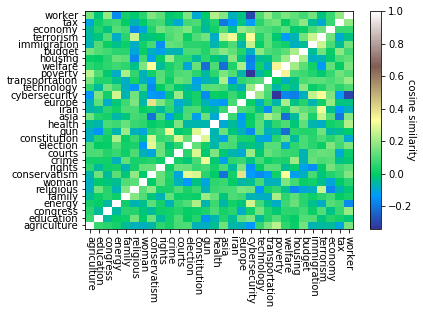

In [28]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

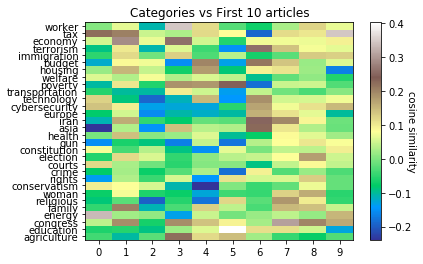

In [29]:
heatmapMatrixC = []
for index in range(10):
    column = []
    tagVec = dataD2V.docvecs[index].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, 
                                            dataD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC.T, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_yticklabels(keywords, minor=False)
a = ax.set_xticklabels(range(10), minor=False)
plt.title('Categories vs First 10 articles')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project, then generate meaningful semantic dimensions based on your theoretical understanding of the semantic space (i.e., by subtracting semantically opposite word vectors) and project another set of word vectors onto those dimensions. Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why? 

<span style="color:red">***Stretch***: Average together multiple antonym pairs to create robust semantic dimensions. How do word projections on these robust dimensions differ from single-pair dimensions?

* I construct four different dimensions: `Gender` (man-woman), `Race` (white-black), `Wealth` (rich-poor), `ideology` (right-left). 
* I focus on `Occupations` and `U.S. presidents`.
* Surprisingly, "politician" and "poet" are the most masculine words--even more than "drivers" and "scientists." I was expecting social scientists are more gender-neutral but it is not the case. Also plumber is quite close white people and driver is close to black people.
* It is also interesting that at the ideology spectrum, trump is located closer to left than right. This is probably because it is so much related to Obama and so much discussed that it is connected to everything. The other presidents are located basically based on their partisanship.

In [30]:
#token = []
#for ind, txt in enumerate(data['cleaned_text']):
    #add = [word_tokenize(x) for x in txt]
    #token.append(add) ## changed word_tokenize to make it faster, see tools.py
    #if ind % 2000 == 0: print(ind)
#data['tokenized_words'] = token
#data.head()
#text = [s for i in data['tokenized_words'] for s in i]
#words_W2V = gensim.models.word2vec.Word2Vec(text)
#words_W2V.save("unnormalized_data_WORD2Vec")

In [31]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    i = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(words_W2V[word].reshape(1,-1), 
                                                            Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(words_W2V[word].reshape(1,-1), 
                                                            Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(words_W2V[word].reshape(1,-1), 
                                                            Class.reshape(1,-1))[0][0])
        i.append(sklearn.metrics.pairwise.cosine_similarity(words_W2V[word].reshape(1,-1), 
                                                            Ideology.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c, 'ideology': i}, index = word_list)
    return df

In [32]:
words_W2V = gensim.models.word2vec.Word2Vec.load("unnormalized_data_WORD2Vec")

In [33]:
Gender = dimension(words_W2V, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(words_W2V, ['white', 'whites', 'caucasian'], ['black','blacks','african'])
Class = dimension(words_W2V, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], 
                             ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])
Ideology = dimension(words_W2V, ['conservative', 'liberalism', 'republicanism', 'republican'],
                                ['liberal', 'progressive', 'progressivism', 'democrat'])

Occupations = ["doctor","lawyer", "plumber", "scientist", "nanny",
               "entrepreneur","writer", "banker","poet","nurse", "politician",
               'worker', 'driver']
people  = ['trump', 'bush', 'obama', 'clinton', 'reagan', 'carter', 'ford', 'nixon', 'truman']

tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','african', 
                   'asian', 'white', 'whites', 'caucasian', 'rich', 'richer', 'richest', 
                   'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
tnytTargetWords += Occupations + people

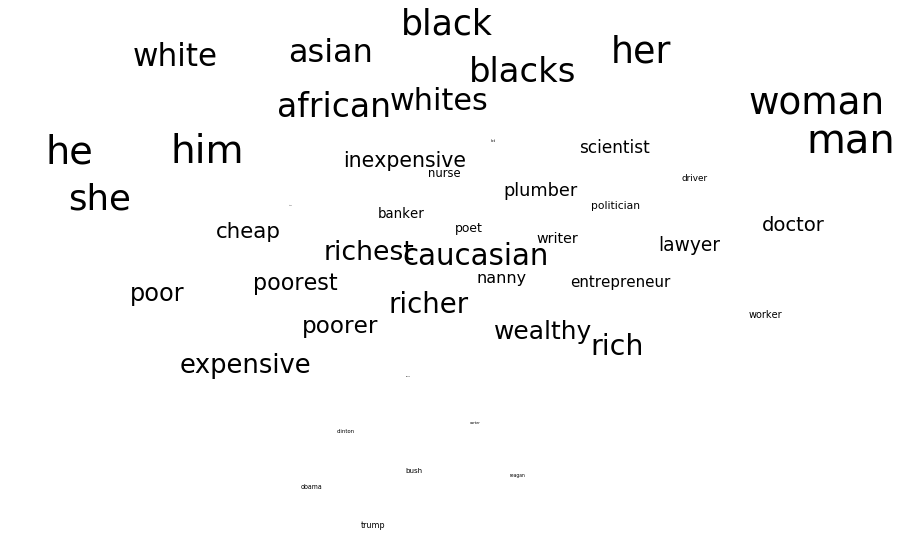

In [34]:
wordsSubMatrix = []
for word in tnytTargetWords:
    try: wordsSubMatrix.append(words_W2V[word])
    except KeyError: 
        print(word)
        continue
wordsSubMatrix = np.array(wordsSubMatrix)

OCCdf = makeDF(words_W2V, Occupations) 
peopledf = makeDF(words_W2V, people)

pcaWordsNYT = sklearn.decomposition.PCA(n_components = 40).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), 
                size =  40 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

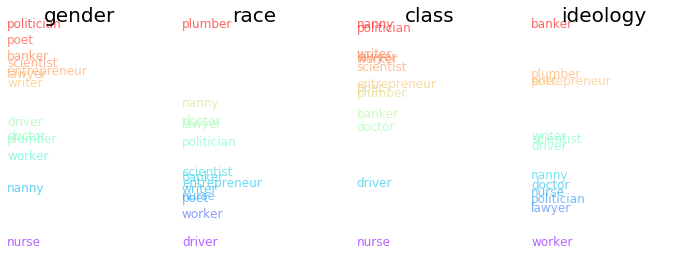

In [35]:
fig = plt.figure(figsize = (12,4))

ax1 = fig.add_subplot(141)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(142)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(143)
PlotDimension(ax3, OCCdf, 'class')
ax4 = fig.add_subplot(144)
PlotDimension(ax4, OCCdf, 'ideology')
plt.show()

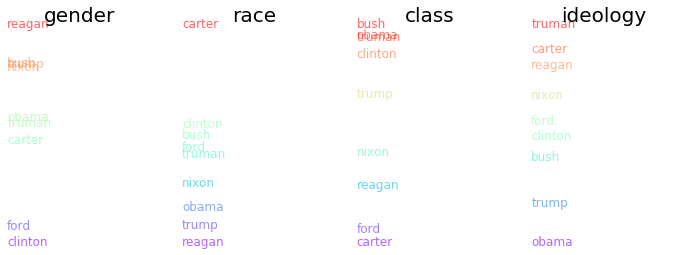

In [36]:
fig = plt.figure(figsize = (12,4))

ax1 = fig.add_subplot(141)
PlotDimension(ax1, peopledf, 'gender')
ax2 = fig.add_subplot(142)
PlotDimension(ax2, peopledf, 'race')
ax3 = fig.add_subplot(143)
PlotDimension(ax3, peopledf, 'class')
ax4 = fig.add_subplot(144)
PlotDimension(ax4, peopledf, 'ideology')
plt.show()

## <span style="color:red">*Exercise 4b*</span>

<span style="color:red">**Do only 4a or 4b.** Construct cells immediately below this that align word embeddings over time or across domains/corpora. Interrogate the spaces that result and ask which words changed most and least over the entire period or between contexts/corpora. What does this reveal about the social game underlying your space? 

* With an update in webscrapping algorithm I can finally compare texts based on time.
* There are 439 words to compare from 1977-2019 -- not a lot, but understandable considering such a long time-frame. There are not a lot of articles in the early years
* For all target words, 1977-2004 seem quite homogeneous, and then between every two year from 2004 to the present the divergence is quite different. This shift somehow started since 2002. I haven't yet understood the reason of this shift--maybe the change of donors or the Iraq war. 
* The linguistic shift, nevertheless tells a lot. For example, the discourse about health changes the most around the time when major legislations were passed. Also, the discussion about Trump grows hot during the year of 2016--but interestingly, in 2017 and 2018 the linguistic difference about Trump is also large.  

In [37]:
def gen_year(x):
    if len(x) > 4: return int(x[-4:])
    else: return 0
data['Year'] = data['date'].apply(lambda x: gen_year(x))
timed_data = data[data['Year'] != 0]
timed_data.shape, data.shape

((15271, 7), (15631, 7))

In [38]:
#data.to_csv('cleaned_data.csv', index = False)

In [39]:
def compareModels(df, category, sort = True):
    """If you are using time as your category sorting is important"""
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #print(subsetDF.shape)
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF['normalized_sents'].sum())
            
    embeddings_r_new = copy.deepcopy(embeddings_raw)
    
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_r_new[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], 
                                                                              embeddings_r_new[catInner]))
        
    return embeddings_raw, embeddings_aligned

In [40]:
#mask = (data['Year']>2014) & (data['Year']<2020)
#mask = data['Year'] == 2015
rawEmbeddings, comparedEmbeddings = compareModels(data, 'Year')

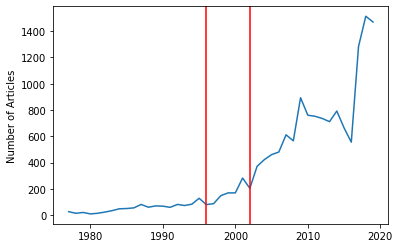

In [41]:
count = timed_data.groupby(['Year']).count()['text']
sns.lineplot(x= range(1977, 2020), y = count[:-1])
plt.ylabel('Number of Articles')
plt.axvline(2002, color = 'red')
plt.axvline(1996, color = 'red')
plt.show()

In [42]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 439 words to compare


In [43]:
wordDivergences[:20]

[('unite', 35.82129903882742),
 ('state', 35.64426086936146),
 ('court', 35.12388608790934),
 ('study', 34.63059443421662),
 ('security', 34.50020296499133),
 ('war', 33.851543720811605),
 ('group', 33.64778381586075),
 ('report', 33.37142722308636),
 ('tax', 33.169190438464284),
 ('president', 33.07648899778724),
 ('general', 32.98701825737953),
 ('accord', 32.9169468767941),
 ('rate', 32.84306639805436),
 ('national', 32.81494038365781),
 ('vote', 32.79884784296155),
 ('law', 32.63458267785609),
 ('department', 32.57760211080313),
 ('percent', 32.55333812255412),
 ('income', 32.47877926006913),
 ('year', 32.22200794517994)]

economic


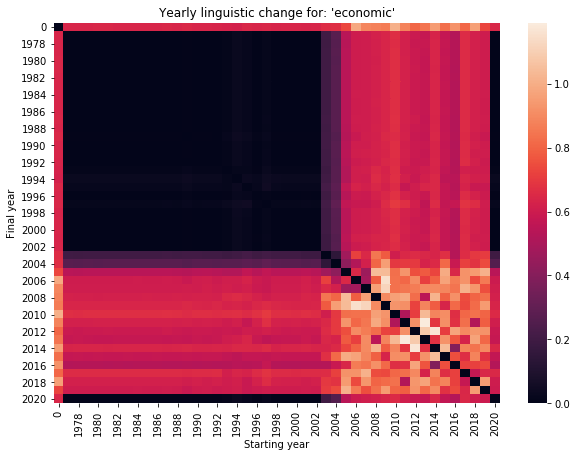

In [44]:
targetWord = 'economic'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

### Health Care Legislation History for Reference
* 1996 The Health Insurance Portability and Accountability Act (HIPAA) not only protects health insurance coverage for workers and their families when they change or lose their jobs, it also made health insurance companies cover pre-existing conditions. If such condition had been diagnosed before purchasing insurance, insurance companies are required to cover it after patient has one year of continuous coverage. If such condition was already covered on their current policy, new insurance policies due to changing jobs, etc... have to cover the condition immediately.[9]
* 1997 The Balanced Budget Act of 1997 introduced two new major Federal healthcare insurance programs, Part C of Medicare and the State Children's Health Insurance Program, or SCHIP. Part C formalized longstanding "Managed Medicare" (HMO, etc.) demonstration projects and SCHIP was established to provide health insurance to children in families at or below 200 percent of the federal poverty line. Many other "entitlement" changes and additions were made to Parts A and B of fee for service (FFS) Medicare and to Medicaid within an omnibus law that also made changes to the Food Stamp and other Federal programs.[10]
* 2000 The Medicare, Medicaid, and SCHIP Benefits Improvement and Protection Act (BIPA) effectively reversed some of the cuts to the three named programs in the Balanced Budget Act of 1997 because of Congressional concern that providers would stop providing services.
* 2003 The Medicare Prescription Drug, Improvement, and Modernization Act (also known as the Medicare Modernization Act or MMA) introduced supplementary optional coverage within Medicare for self-administered prescription drugs and as the name suggests also changed the other three existing Parts of Medicare law.
https://en.wikipedia.org/wiki/Healthcare_reform_in_the_United_States

health


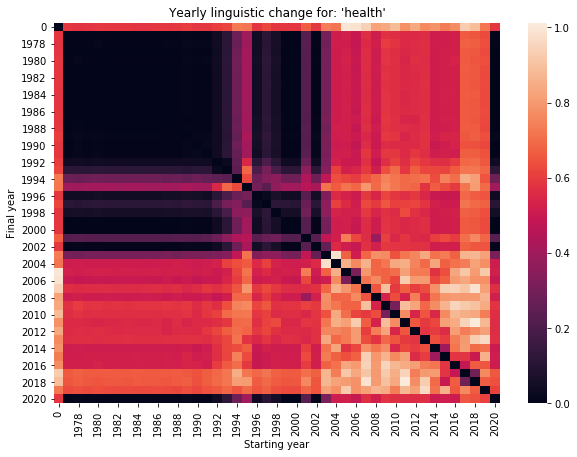

In [45]:
targetWord = 'health'
# Clinton health care plan of 1993
pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

trumpding 2018


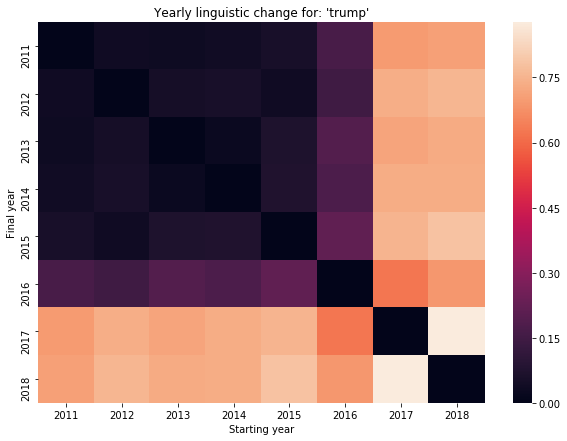

In [46]:
mask = (data['Year']>2010) & (data['Year']<2019)
rawEmbeddings, comparedEmbeddings = compareModels(data[mask], 'Year')

targetWord = 'trump'
# 2016: Obama -> Trump Election?
pltDF = getDivergenceDF(targetWord, comparedEmbeddings, range(2011, 2019))
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) 
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()